### DHO Likehood Surface Visualization

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 08-17-20
<br>**Short description:** Notebook for testing different global optimizer for DHO fitting where local minima is observed very often.

In [71]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline
# mpl.rcParams['text.usetex'] = False
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams['figure.figsize'] = (8,6)

In [5]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
from scipy.optimize import minimize
import celerite

In [6]:
from dask.distributed import Client
client = Client()
client

/Users/weixiang/anaconda3/envs/py37/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57727 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:57728 Dashboard: http://127.0.0.1:57727/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


### 1. Simulate DHO LC

In [7]:
# define GP model
a1 = 0.03939692
a2 = 0.00027941
b0 = 0.0046724
b1 = 0.0256982
kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
gp = GP(kernel)

# check if Celerite give the same amp as Kali
assert np.allclose(1.0, kernel.get_amp())

In [8]:
# now simulate 10 years LC
npts = 100
nLC = 50

# init with dense -> add season -> downsample
t_init = np.linspace(0, 3650, 10000)
yerr_init = np.random.normal(0, 1e-7, 10000) # give very tiny error
gp.compute(t_init, yerr_init)
y_init = gp.sample(size=nLC)

tArr = np.zeros((nLC, npts))
yArr = np.zeros((nLC, npts))
yerrArr = np.zeros((nLC, npts))

for i in range(nLC):    
    mask1 = add_season(t_init)
    mask2 = downsample_byN(t_init[mask1], npts)
    tArr[i,:] = t_init[mask1][mask2]
    yArr[i,:] = y_init[i][mask1][mask2]
    yerrArr[i,:] = yerr_init[mask1][mask2]


print(f'Mean Sim Std: {np.mean(np.std(yArr, axis=1))}')
print(f'True Std: {1}')

Mean Sim Std: 0.9626694231239606
True Std: 1


Text(0.5, 1.0, 'Simulated DHO LC with Seasonal Gap')

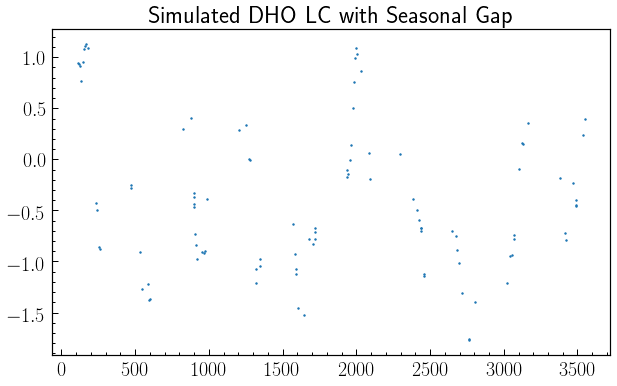

In [9]:
# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(tArr[0], yArr[0], s=2)
plt.title('Simulated DHO LC with Seasonal Gap')

### 2. Test __basin-hopping__ algorithm

In [10]:
from scipy.optimize import basinhopping

# define log posterior function
def neg_log_like(params, y, yerr, gp):
    params = np.array(params)
    # pure likelihood based
    run = True
    lap = 0
    while run:
        if lap > 50:
            return -np.inf
        
        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run=False
        except celerite.solver.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        
    return neg_ll


# # # define vectorized version
# vec_neg_log_like = np.vectorize(neg_log_like, excluded=[1,2,3], signature='(n)->()')
# vec_neg_log_prob = np.vectorize(neg_log_prob, excluded=[1,2,3], signature='(n)->()')

In [30]:
# bounds for optimizer
class MyBounds(object):
    def __init__(self, xmin, xmax, **kwargs):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
     
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        print(kwargs['x_old'], kwargs['x_new'])
#         print(kwargs['x_new'])
        return (tmax and tmin)

xmin=np.array([-10, -14, -12, -11])
xmax=np.array([7, 7, -2, -2])
mybounds = MyBounds(xmin=xmin, xmax=xmax)

In [58]:
def fitDHO_bh(t, y, yerr, prob_func):
    
    ## start fitting
    # initialize parameter in the possible range
    a1 = np.exp(np.random.uniform(-3, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-6, 1, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

    kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    minimizer_kwargs = {"method":"L-BFGS-B", "args": (y, yerr, gp_fit)}
    initial_params = gp_fit.get_parameter_vector()

    ret = basinhopping(prob_func, initial_params, minimizer_kwargs=minimizer_kwargs, \
                       niter_success=200)
    return ret.x

def fitDHO_bh_dask(idx, prob_func):
    
    run=True
    t = tArr[idx]
    y = yArr[idx]
    yerr = yerrArr[idx]
    
    while run:
        ## start fitting
        # initialize parameter in the possible range
        a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
        a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
        b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
        b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

        kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
        gp_fit = GP(kernel_fit)
        gp_fit.compute(t, yerr)

        minimizer_kwargs = {"method":"L-BFGS-B", "args": (y, yerr, gp_fit)}
        initial_params = gp_fit.get_parameter_vector()
        print(f'Init: {initial_params}')
        ret = basinhopping(prob_func, initial_params, minimizer_kwargs=minimizer_kwargs, 
                           niter_success=30, accept_test=mybounds, stepsize=4)
    
        # sometime basinhopping suggest something extremely off in the first
        # iteration and will accept with no condition, this if clause check 
        # whether that's true, if so, redo the whole process
        if np.all(ret.x <= xmax) and np.all(ret.x >= xmin):
            run = False

#     # if can't factorize, resample
#     while run:
#         try:
#             gp_fit.set_parameter_vector([np.log(a1), np.log(a2), np.log(b0), np.log(b1)])

#             run=False
#         except celerite.solver.LinAlgError as e:
#             print(e)
#             # if can't factorize, redo random down sampling
# #             mask1 = add_season(t_init)
# #             mask2 = downsample_byN(t_init[mask1], npts)
# #             t = tArr[idx,:] = t_init[mask1][mask2]
# #             y = yArr[idx,:] = y_init[i][mask1][mask2]
# #             yerr = yerrArr[idx,:] = yerr_init[mask1][mask2]
#             continue  
#         except np.linalg.LinAlgError as e:
#             print(e)
#             continue
        
    return ret.x

In [59]:
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_bh_dask, i, neg_log_like)
    ret_all.append(ret)

result= client.gather(ret_all, errors='skip')

In [ ]:
# fitDHO_bh_dask(40, neg_log_like)

### 2.1 Plot the Err distribution

In [60]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(result))
percent_err = 100*(best_params - input_params)/input_params

Text(0.5, 0, 'Percentage Error')

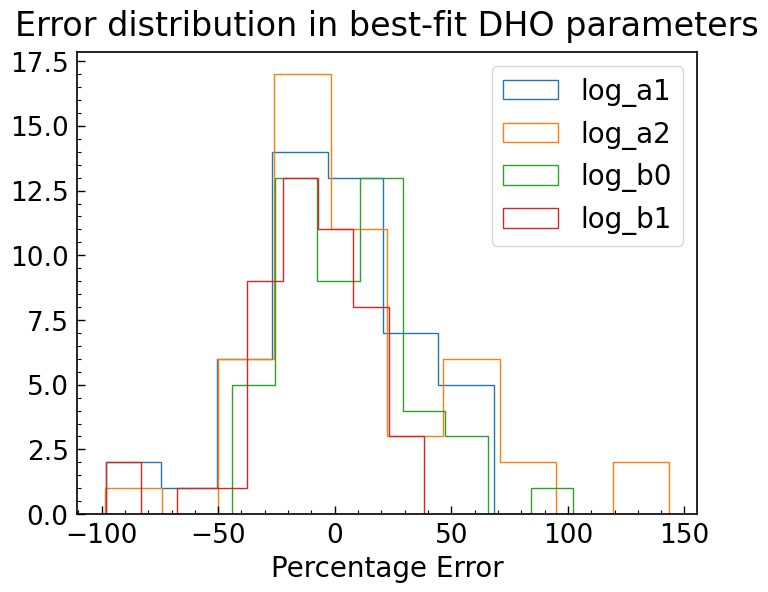

In [91]:
param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', bins='fd')
plt.legend()
plt.title('Error distribution in best-fit DHO parameters')
plt.xlabel('Percentage Error')

<span style='color:red'>__Note:__ </span>After a series of fine tuning, I am able to reduce the error in best-fit parameter down to +/- 100%. It is still possible to get best-fit parameter that are quite off, the next level of improvement can come from multiple random initialization for each fit and pick the best one. As seen in the figure above, DHO also exhibits similar kind error distribution as the DRW, which cannot be further reduce.